# Introducción
El objetivo de este proyecto es desarrollar un modelo de deep learning capaz de clasificar imágenes de personajes de Los Simpsons utilizando una técnica conocida como "pérdida de las trillizas" (triplet loss). Esta técnica permite al modelo aprender una representación de las imágenes en un espacio donde aquellas del mismo personaje estén más cerca entre sí, y las de personajes diferentes estén más alejadas. Este enfoque es especialmente útil en tareas de reconocimiento facial, verificación de identidad entre otras.



## Librerías a utilizar

Se importan todas las librerías necesarias para la manipulación de imágenes, creación del dataset, entrenamiento de modelos, visualización, y descarga de archivos.

In [1]:
import os
from typing import Optional, Callable
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import csv
import random
from itertools import combinations
from collections import defaultdict
import gdown
import zipfile
from sklearn.model_selection import train_test_split
import gc
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim


## Configuración del repositorio

### Descarga y descompresión del datset

En esta celda descargamos el dataset comprimido en formato .zip desde un enlace público de Google Drive y lo descomprimimos para poder acceder a las imágenes.

In [2]:
# Configura si se está usando Colab o local
using_colab = False  # ← Cambia esto a True si estás en Colab

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    REPO_PATH = "/content/drive/MyDrive/Data/simpsons_dataset"
else:
    REPO_PATH = "."


# Descargar el zip del dataset-

# URL del archivo compartido desde Drive (convertido a formato directo para gdown)
url = "https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub"
output = os.path.join(REPO_PATH, "simpsons_dataset.zip")

print(f"Descargando dataset desde Drive a: {output}")
gdown.download(url, output, quiet=False)


# Descomprimir el ZIP principal

print(f"Extrayendo: {output}")
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(REPO_PATH)


# Ruta final al dataset

DATASET_PATH = os.path.join(REPO_PATH, "simpson_dataset")  # ← carpeta con subcarpetas por personaje
ANNOTATION_FILE = os.path.join(REPO_PATH, "annotation.txt")  # ← archivo de anotaciones


Descargando dataset desde Drive a: ./simpsons_dataset.zip


Downloading...
From (original): https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub
From (redirected): https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub&confirm=t&uuid=282a8a4b-4e61-4218-8642-e263f8f5a983
To: /content/simpsons_dataset.zip
100%|██████████| 1.16G/1.16G [00:15<00:00, 76.7MB/s]


Extrayendo: ./simpsons_dataset.zip


### Generación del CSV de entrenamiento y test

Las siguientes funciones procesan el dataset de imágenes de Los Simpsons. Primero, la función `split_annotations` divide las anotaciones en conjuntos de entrenamiento y prueba, corrigiendo rutas y filtrando etiquetas con pocas imágenes. Luego, la función `generate_triplets_from_annotation_csv` genera tripletas (anchor, positive, negative) para cada conjunto, necesarias para entrenar modelos con pérdida triplet (triplet loss).

In [3]:
def split_annotations(annotation_path, root_dir, train_output, test_output, test_size=0.2):
    label_to_entries = defaultdict(list)

    with open(annotation_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) != 6:
                print(f"[!] Línea ignorada (formato incorrecto): {line.strip()}")
                continue
            path, x1, y1, x2, y2, label = parts

            # Limpiar ruta para que coincida con la estructura real
            if path.startswith("./characters/"):
              path = path[len("./characters/"):]
            elif path.startswith("./characters2/"):
                path = path[len("./characters2/"):]

            full_path = os.path.join(root_dir, path)
            if not os.path.isfile(full_path):
                print(f"[!] ¡Archivo NO existe!: {full_path}")
            entry = {
                'path': full_path,
                'bbox': f"{x1},{y1},{x2},{y2}",
                'label': label
            }
            label_to_entries[label].append(entry)

    train_entries, test_entries = [], []
    for entries in label_to_entries.values():
        if len(entries) < 3:
            print(f"[!] Etiqueta con muy pocas imágenes, ignorada: {entries[0]['label']}")
            continue
        train, test = train_test_split(entries, test_size=test_size, random_state=42)
        train_entries.extend(train)
        test_entries.extend(test)

    def save_csv(entries, output_path):
        with open(output_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['path', 'bbox', 'label'])
            for e in entries:
                writer.writerow([e['path'], e['bbox'], e['label']])

    save_csv(train_entries, train_output)
    save_csv(test_entries, test_output)
    print(f"[+] CSVs generados: {train_output} ({len(train_entries)} entradas), {test_output} ({len(test_entries)} entradas)")

def generate_triplets_from_annotation_csv(annotation_csv, output_csv, num_triplets=10000):
    label_to_entries = defaultdict(list)

    with open(annotation_csv, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            path = row['path']
            bbox = row['bbox']
            label = row['label']
            label_to_entries[label].append({'path': path, 'bbox': bbox, 'label': label})

    triplets = []
    labels = list(label_to_entries.keys())

    for _ in range(num_triplets):
        anchor_label = random.choice(labels)
        while len(label_to_entries[anchor_label]) < 2:
            anchor_label = random.choice(labels)

        negative_label = random.choice([l for l in labels if l != anchor_label])

        anchor, positive = random.sample(label_to_entries[anchor_label], 2)
        negative = random.choice(label_to_entries[negative_label])

        triplets.append((
            anchor['path'], anchor['bbox'], anchor['label'],
            positive['path'], positive['bbox'], positive['label'],
            negative['path'], negative['bbox'], negative['label']
        ))

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'anchor_path', 'anchor_bbox', 'anchor_label',
            'positive_path', 'positive_bbox', 'positive_label',
            'negative_path', 'negative_bbox', 'negative_label'
        ])
        writer.writerows(triplets)

    print(f"[+] Tripletas generadas: {len(triplets)} → {output_csv}")

if __name__ == "__main__":
    root_dir = 'simpsons_dataset'

    annotation_txt = 'annotation.txt'

    # Paso 1: dividir anotaciones y corregir rutas
    split_annotations(
        annotation_path=annotation_txt,
        root_dir=root_dir,
        train_output='annotations_train.csv',
        test_output='annotations_test.csv',
        test_size=0.2
    )

    # Paso 2: generar tripletas para train y test
    generate_triplets_from_annotation_csv('annotations_train.csv', 'triplets_train.csv', num_triplets=15000)
    generate_triplets_from_annotation_csv('annotations_test.csv', 'triplets_test.csv', num_triplets=3000)


[+] CSVs generados: annotations_train.csv (5395 entradas), annotations_test.csv (1357 entradas)
[+] Tripletas generadas: 15000 → triplets_train.csv
[+] Tripletas generadas: 3000 → triplets_test.csv


# Dataset de personajes de los simpsons


Para abordar este proyecto, utilizamos el dataset [The Simpsons Characters Data](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset/data). Este conjunto de datos contiene imágenes de los persoanjes de la serie donde los tamaños de las imagenes son diferentes y necesitaran un pre-procesamiento.

El dataset incluye un total de 41.866 imágenes

## clase `TripletImageDataset`

la siguiente clase lee las tripletas de imágenes desde el archivo CSV generado anteriormente y las prepara para ser utilizadas durante el entrenamiento de los modelos

In [4]:
class TripletImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.triplets = []

        with open(csv_file, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.triplets.append(row)

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
      triplet = self.triplets[idx]

      anchor_path = triplet['anchor_path']
      positive_path = triplet['positive_path']
      negative_path = triplet['negative_path']

      anchor_img = Image.open(anchor_path).convert('RGB')
      positive_img = Image.open(positive_path).convert('RGB')
      negative_img = Image.open(negative_path).convert('RGB')

      if self.transform:
          anchor_img = self.transform(anchor_img)
          positive_img = self.transform(positive_img)
          negative_img = self.transform(negative_img)

      return anchor_img, positive_img, negative_img



Antes de pasar las iamgenes a los modelos es necesario aplciar la siguiente transformacion para redimensionar las imagenes y normalizar la media y desviacion estandar.
Luego se cargan los datasets y por último se crean los dataloaders.

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = TripletImageDataset('triplets_train.csv', transform=transform)
test_dataset = TripletImageDataset('triplets_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
import os
print(os.path.exists('/content/simpsons_dataset/ned_flanders/pic_1303.jpg'))  # True o False


True


## Redes a evaluar

evaluaremos tres arquitecturas diferentes de redes neuronales convolucionales, cada una con características específicas

Se decidió usar tres modelos de computer vision preentrenados como backbones para extraer representaciones (embeddings) de las imagenes:
- **ResNet18**: usa bloques residuales para evitar el problema del desvanecimiento del gradiente al aumentar la profundidad del modelo
- **EfficientNet-B0**: escala de forma eficiente la profundidad, ancho y resolución de entrada, logrando un gran rendimiento con menor cantidad de parámetros
- **DenseNet121**: cada capa está conectada con todas las anteriores, lo que mejora significativamente el flujo de información y gradientes durante el entrenamiento

Todos estos modelos fueron originalmente entrenados en ImageNet y luego seran adaptados mediante fine-tuning para la tarea especifica de aprendizaje por similitud.

la siguiente clase permite reutilizar la arquitectura preentrenada (backbone), eliminando su capa final de clasificación y reemplazándola por una nueva capa Linear que genera un vector de salida de tamaño reducido (por defecto, 128 dimensiones).

In [13]:
class EmbeddingNet(nn.Module):
    def __init__(self, backbone='resnet18', embedding_size=128):
        super().__init__()
        self.backbone_name = backbone
        self.embedding_size = embedding_size

        if backbone == 'resnet18':
            base = models.resnet18(pretrained=True)
            in_features = base.fc.in_features
            base.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            base = models.efficientnet_b0(pretrained=True)
            in_features = base.classifier[1].in_features
            base.classifier = nn.Identity()
        elif backbone == 'densenet121':
            base = models.densenet121(pretrained=True)
            in_features = base.classifier.in_features
            base.classifier = nn.Identity()
        else:
            raise ValueError(f"Backbone {backbone} no soportado.")

        self.backbone = base
        self.embedding = nn.Linear(in_features, embedding_size)

    def forward(self, x):
        x = self.backbone(x)
        return self.embedding(x)


### Función principal de entrenamiento

En esta funcion se realiza una pasada completa de entrenamiento del modelo usando tripletas de imágenes (ancla, positiva y negativa). Por cada batch, calcula los embeddings de las imágenes, evalúa la pérdida con una función específica para aprendizaje por tripletas, y actualiza los pesos del modelo con descenso por gradiente. Finalmente, devuelve la pérdida promedio para monitorear el progreso del entrenamiento.

In [14]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for anchor, positive, negative in tqdm(dataloader, desc="Train"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        emb_a = model(anchor)
        emb_p = model(positive)
        emb_n = model(negative)

        loss = loss_fn(emb_a, emb_p, emb_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


A continuación se define una función de evaluación llamada `evaluate`, que permite medir el rendimiento del modelo de embeddings utilizando la pérdida de la trilliza (Triplet Loss)

In [15]:
# Evaluación (distancias)
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for anchor, positive, negative in tqdm(dataloader, desc="Eval"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)
            loss = loss_fn(emb_a, emb_p, emb_n)
            total_loss += loss.item()
    return total_loss / len(dataloader)


## Función de entrenamiento de todos los modelos

In [69]:
def train_all_backbones(train_csv, test_csv, device,
                       embedding_size=128, batch_size=32, epochs=10, learning_rate=1e-4, margin=1.0):

    backbones = ['resnet18', 'densenet121', 'efficientnet_b0']

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_dataset = TripletImageDataset(train_csv, transform=transform)
    test_dataset = TripletImageDataset(test_csv, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for backbone in backbones:
        print(f"\n=== Entrenando con backbone: {backbone} ===")

        model = EmbeddingNet(backbone=backbone, embedding_size=embedding_size).to(device)
        loss_fn = nn.TripletMarginLoss(margin=margin)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            test_loss = evaluate(model, test_loader, loss_fn, device)
            print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

        # Guardar modelo para cada backbone
        torch.save(model.state_dict(), f"triplet_model_{backbone}.pth")
        print(f"Modelo {backbone} guardado correctamente.\n")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_all_backbones('triplets_train.csv', 'triplets_test.csv', device)


=== Entrenando con backbone: resnet18 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 1/10


Eval: 100%|██████████| 94/94 [03:05<00:00,  1.97s/it]


Train Loss: 0.2604 | Test Loss: 0.2090
Epoch 2/10


Eval: 100%|██████████| 94/94 [03:04<00:00,  1.97s/it]


Train Loss: 0.0308 | Test Loss: 0.2125
Epoch 3/10


Train:   9%|▉         | 43/469 [04:01<39:51,  5.61s/it]


KeyboardInterrupt: 

## Carga de modelos

La siguiente función permite cargar los pesos de entrenamiento de las redes en estudio en caso de desconectarse y volver a conectarse en collab.

In [70]:
def load_trained_model(backbone, model_path, embedding_size=128, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = EmbeddingNet(backbone=backbone, embedding_size=embedding_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model


Para evaluar la efectividad de los modelos de embeddings ya entrenados se definió la clase `classify_and_show_random_test_image`

In [71]:
@torch.no_grad()
def classify_and_show_random_test_image(model, test_annotation_csv, transform, reference_embeddings, device):
    df = pd.read_csv(test_annotation_csv)
    sample = df.sample(1).iloc[0]

    img_path = sample['path']
    label_true = sample['label']
    bbox = list(map(int, sample['bbox'].split(',')))

    img = Image.open(img_path).convert('RGB')
    cropped = img.crop(bbox)
    input_tensor = transform(cropped).unsqueeze(0).to(device)

    model.eval()
    embedding = model(input_tensor).cpu().numpy()

    # Comparar contra embeddings de referencia
    distances = {
        ref_label: np.linalg.norm(embedding - ref_emb)
        for ref_label, ref_emb in reference_embeddings.items()
    }

    predicted_label = min(distances, key=distances.get)

    # Mostrar imagen con predicción
    plt.imshow(cropped)
    plt.title(f'Verdadero: {label_true} | Predicho: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label, label_true


## Generación de Embeddings de referencia por clase

La función compute_reference_embeddings tiene como objetivo construir un conjunto representativo de vectores de referencia (embeddings) para cada clase  presente en el conjunto de imágenes.
Esto permite reducir la tarea a una comparación directa entre el embedding de una imagen de prueba y los promedios de cada clase previamente calculados

In [80]:
def compute_reference_embeddings(model, annotation_csv, transform, device, samples_per_class=3):
    import pandas as pd
    from collections import defaultdict
    import numpy as np
    from PIL import Image

    df = pd.read_csv(annotation_csv)
    grouped = df.groupby('label')
    reference_embeddings = {}

    model.eval()
    with torch.no_grad():
        for label, group in grouped:
            embeddings = []
            sampled_group = group.sample(min(samples_per_class, len(group)))
            for _, row in sampled_group.iterrows():
                img = Image.open(row['path']).convert('RGB')
                bbox = list(map(int, row['bbox'].split(',')))

                # Asegurar orden correcto de coordenadas
                x1, y1, x2, y2 = bbox
                x1, x2 = min(x1, x2), max(x1, x2)
                y1, y2 = min(y1, y2), max(y1, y2)
                corrected_bbox = (x1, y1, x2, y2)

                try:
                    cropped = img.crop(corrected_bbox)
                    tensor = transform(cropped).unsqueeze(0).to(device)
                    emb = model(tensor).cpu().numpy()
                    embeddings.append(emb)
                except Exception as e:
                    print(f"Error procesando {row['path']} con bbox {bbox}: {e}")

            if embeddings:
                reference_embeddings[label] = np.mean(embeddings, axis=0)

    return reference_embeddings


## Prueba de los modelos

A continuación se ejecuta todo el pipeline probando los modelos entrenados cpasandole una imagen aleatoria para verificar que hace lo correcto.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


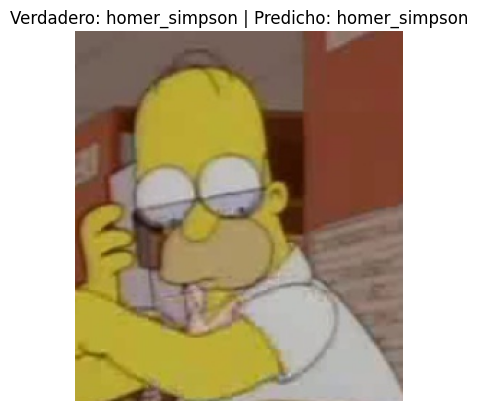

('homer_simpson', 'homer_simpson')

In [94]:
import torch
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Cargar el modelo entrenado
model = load_trained_model('densenet121', 'triplet_model_densenet121.pth', device=device)

# 2. Crear embeddings de referencia
reference_embeddings = compute_reference_embeddings(model, 'annotations_train.csv', transform, device)

# 3. Clasificar una imagen de test
classify_and_show_random_test_image(model, 'annotations_test.csv', transform, reference_embeddings, device)


# Conclusión



Analizando los resultados obtenidos para cada modelo en su entrenamiento:

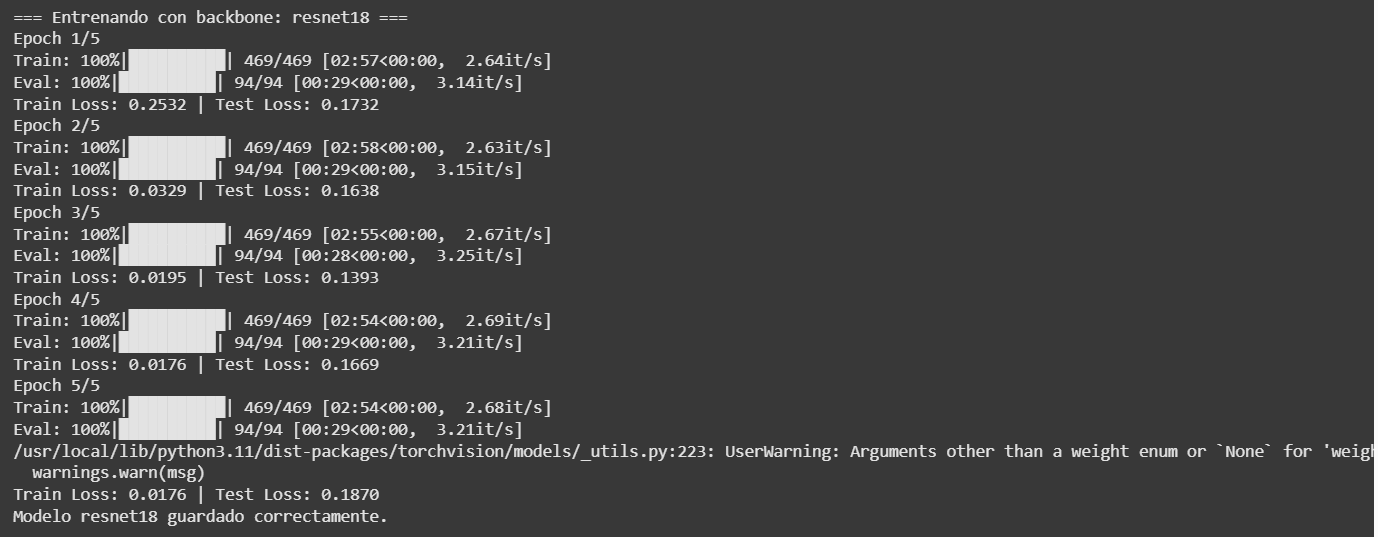

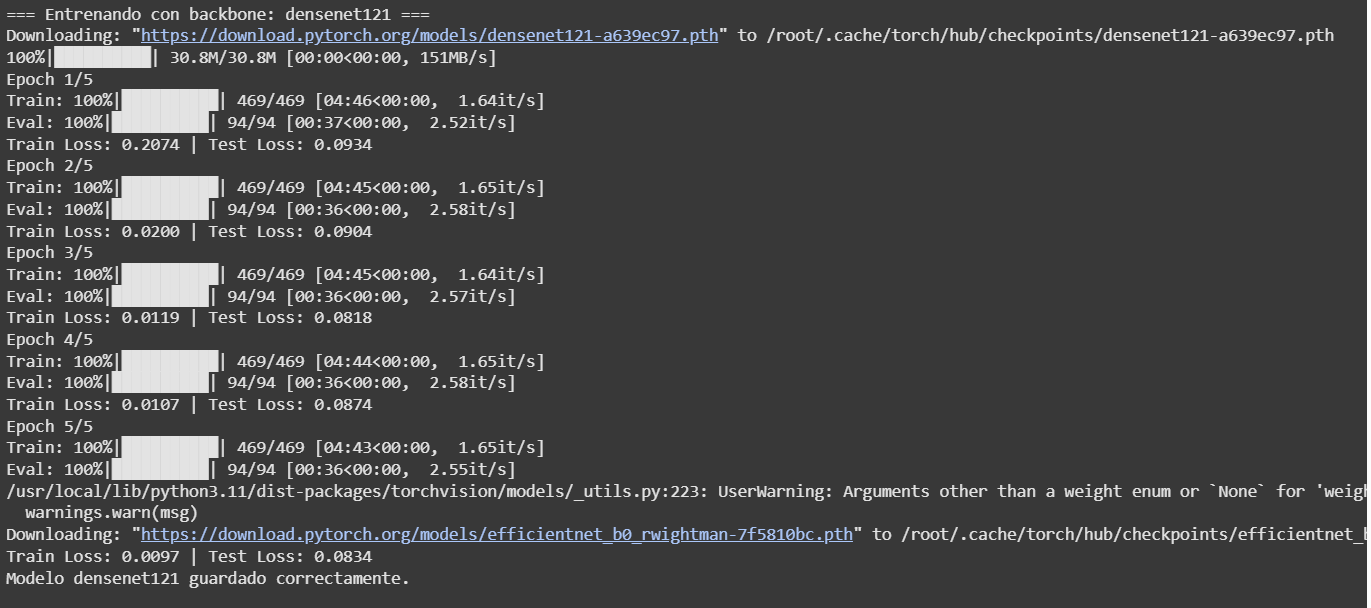

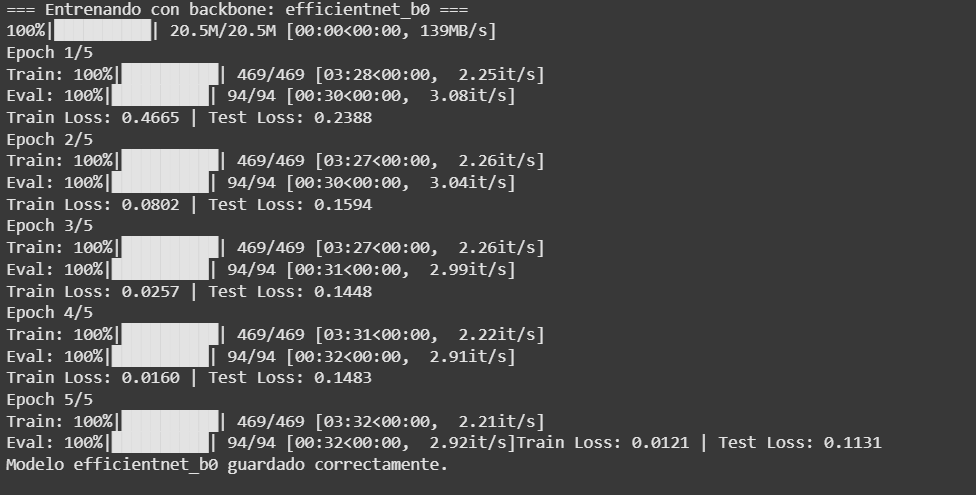

Podemos ver que bajo las misma condiciones de hiperparametros como el batch size y cantidad de epocs, podemos decir qeu el mejor modelo es el densenet121 porque pbtuvimos una perdida de testeo del 8%, mucho menor comparado con el 11% de la efficient_net y el 18% de la resnet18.